# 데이콘 이상탐지 데이터 분석
---

In [1]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.signal import butter, filtfilt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import ast
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\leonk\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


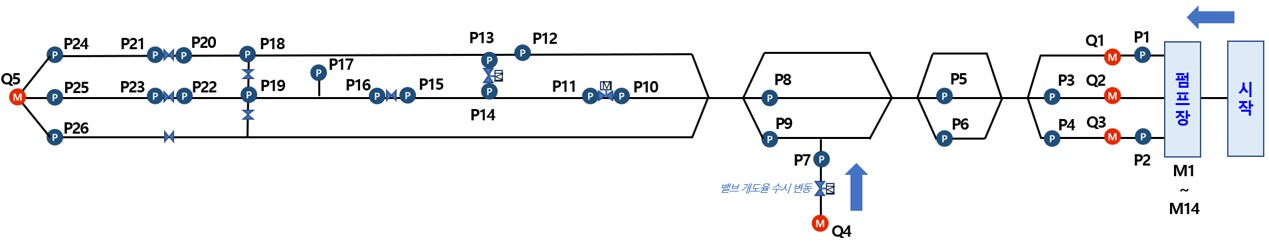

In [2]:
#밸브 개도율 압력계: p7, p10,p11,p13,p14,p15,p16,p18,p19,p20,p21,p22,p23

# M7펌프가 24/06/26 05:58 1에서 0으로 변함
# 압력계가 비정상이되면 14:20-부터 급격히 떨어지다가 정상화된 14:50부터 다시 올라감
- P가 anomaly 관측에 주요 변수로 보임(P8)
- 밸브 개도율 수시 변동과 p8 p9 사이 상관관계 가능
- Q4는 굉장히 중요한 변수다
- Q5가 완전 음에서 완전 양으로 바뀐다
- p7하고 q4가 상관관계 -1에 가까워 q4와 p7사이에 밸브는 개도율이 수시로 변동한다 
- p7이 압력이 높아졌을 때 밸브를 닫아서 q4의 유량이 감소했을 가능성이 있음
- 베르누이 원리에 의해서 정상상태에서는 유량과 압력이 음의 상관관계다
- 근데 anomaly상황에서 q5에서 양의 상관관계다
Anomaly 상황에서 유량과 압력이 양의 상관관계를 보이는 것은 시스템에 비정상적인 상태가 발생했음을 시사합니다. 이는 다음과 같은 상황을 나타낼 수 있습니다:
누수 발생: 파이프라인에 누수가 발생하면, 압력이 증가함에 따라 누수 지점을 통한 유량도 증가할 수 있습니다2. 이는 정상적인 흐름과는 다른 패턴을 보이게 됩니다.
막힘 현상: 파이프라인에 부분적인 막힘이 발생하면, 압력이 증가하면서 동시에 유량도 증가할 수 있습니다. 이는 막힘을 통과하기 위해 더 높은 압력이 필요하기 때문입니다2.
펌프 오작동: 시스템 내 펌프가 비정상적으로 작동하면, 압력과 유량이 동시에 증가하는 현상이 나타날 수 있습니다3.
밸브 오작동: 제어 밸브가 제대로 작동하지 않으면, 압력과 유량 사이의 정상적인 관계가 무너질 수 있습니다.
결론
이러한 관찰 결과는 시스템의 정상 상태와 비정상 상태를 구분하는 중요한 지표가 될 수 있습니다4. 유량과 압력 사이의 관계가 갑자기 변화하는 것은 시스템에 문제가 발생했음을 나타내는 신호일 수 있으며, 이를 통해 조기에 문제를 감지하고 대응할 수 있습니다. 따라서 이러한 패턴 변화를 모니터링하는 것은 수도 공급 시스템의 효율적인 관리와 유지보수에 매우 중요합니다5.

두 그래프의 leakage 패턴과 anomaly 발생 특성을 분석해보면, 다음과 같은 시계열 이상 탐지 모델들이 적합해 보입니다:
1. LSTM Autoencoder
leakage의 시계열 패턴을 학습하여 정상 패턴에서 벗어난 부분을 탐지
특히 df_A와 df_B의 서로 다른 leakage 범위와 패턴을 각각 학습 가능
2. Isolation Forest
leakage의 급격한 변화(jump)를 효과적으로 탐지
데이터의 분포가 다른 두 데이터셋에도 적용 가능한 비모수적 방법
3. ARIMA + 이상치 탐지
leakage의 시계열 특성을 모델링하고 예측값과의 큰 차이를 anomaly로 탐지
각 데이터셋의 고유한 시계열 특성을 반영 가능

# 데이터 정보

In [3]:
df_A = pd.read_csv("TRAIN_A.csv")

print(df_A.columns)
print("칼럼 수 : ",len(df_A.columns))
print("차원 : ",df_A.shape)


# 새로운 열 생성: Q5 - (Q1 + Q2 + Q3 + Q4)
df_A['leakage'] = df_A['Q1'] + df_A['Q2'] + df_A['Q3'] + df_A['Q4'] - df_A['Q5']

Index(['timestamp', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'M1', 'M2', 'M3', 'M4', 'M5',
       'M6', 'M7', 'M8', 'M9', 'M10', 'M11', 'M12', 'M13', 'M14', 'P1', 'P2',
       'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13',
       'P14', 'P15', 'P16', 'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23',
       'P24', 'P25', 'P26', 'anomaly', 'P1_flag', 'P2_flag', 'P3_flag',
       'P4_flag', 'P5_flag', 'P6_flag', 'P7_flag', 'P8_flag', 'P9_flag',
       'P10_flag', 'P11_flag', 'P12_flag', 'P13_flag', 'P14_flag', 'P15_flag',
       'P16_flag', 'P17_flag', 'P18_flag', 'P19_flag', 'P20_flag', 'P21_flag',
       'P22_flag', 'P23_flag', 'P24_flag', 'P25_flag', 'P26_flag'],
      dtype='object')
칼럼 수 :  73
차원 :  (44101, 73)


In [4]:
df_B = pd.read_csv("TRAIN_B.csv")

print(df_B.columns)
print("칼럼 수 : ",len(df_B.columns))
print("차원 : ",df_B.shape)


# 새로운 열 생성:
df_B['leakage'] = df_B['Q1'] - df_B['Q2'] -df_B['Q3'] - df_B['Q4']

Index(['timestamp', 'Q1', 'Q2', 'Q3', 'Q4', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6',
       'P7', 'P8', 'P9', 'P10', 'anomaly', 'P1_flag', 'P2_flag', 'P3_flag',
       'P4_flag', 'P5_flag', 'P6_flag', 'P7_flag', 'P8_flag', 'P9_flag',
       'P10_flag'],
      dtype='object')
칼럼 수 :  26
차원 :  (41760, 26)


`-` 해결해야할 문제 : P 압력계에서 일어나는 이상치를 탐지

- Q1 ~ Q5 : 유량 정량 정보
- M1 ~ M14 : 이진 분류되어진 펌프가동정보, 이산형 데이터 0이면 꺼진거 1이면 켜진거
- P1 ~ P26 : 해당 펌프의 상수도의 압력계 정량 정보 0이면 정상 1이면 이상치!!
- P1_flag ~ P26_flag : 어떠한 P에 이상 탐지 여부, 이진 분류, test set에선 제공되지 않는다
- anomaly : 이상 탐지 여부, train set에서만 존재, P1_flag ~ P26_flag에서 감지되면 해당 변수에서도 체크된다, test set에선 제공되지 않는다
- Data set : $ D_{train} \in R^{n \times m} $ , $n = 1,2,...,44101,\quad m = 1,2,...,73$
- $n$단위는 1분, 결측치 존재 X


`-` 해결해야할 문제 : P 압력계에서 일어나는 이상치를 탐지

- Q1 ~ Q4 : 유량 정량 정보
- M없음, 펌프가 없음
- P1 ~ P10 : 해당 펌프의 상수도의 압력계 정량 정보 0이면 정상 1이면 이상치!!
- P1_flag ~ P10_flag : 어떠한 P에 이상 탐지 여부, 이진 분류, test set에선 제공되지 않는다
- anomaly : 이상 탐지 여부, train set에서만 존재, P1_flag ~ P26_flag에서 감지되면 해당 변수에서도 체크된다, test set에선 제공되지 않는다
- Data set : $ D_{train} \in R^{n \times m} $ , $n = 1,2,...,44101,\quad m = 1,2,...,73$
- $n$단위는 1분, 결측치 존재 X

In [5]:
#시계열 자료로 변환
#df_A['timestamp'] = pd.to_datetime(df_A['timestamp'], format='%y/%m/%d %H:%M')

In [6]:
#df_A['timestamp'].head()

In [7]:
# 1단계: 향상된 특성 추출
def create_advanced_features(df):
    features = df.copy()
    
    # Leakage Jump 특성 강화
    features['leakage_diff'] = features['leakage'].diff()
    features['leakage_abs_diff'] = features['leakage_diff'].abs()
    features['leakage_jump'] = (features['leakage_abs_diff'] > features['leakage_abs_diff'].std() * 2).astype(int)
    
    # Jump 지속시간 특성
    features['jump_duration'] = features['leakage_jump'].rolling(window=10).sum()
    
    # 압력 센서 변화 특성 추가
    pressure_cols = [col for col in df.columns if col.startswith('P') and not col.endswith('flag')]
    
    # Butterworth 필터 파라미터
    nyq = 0.5
    cutoff = 0.1
    b, a = butter(4, cutoff/nyq, btype='low')
    
    # Leakage filtered
    features['leakage_filtered'] = filtfilt(b, a, features['leakage'])
    
    # 각 압력 센서에 대한 특성 생성
    for col in pressure_cols:
        # 압력 변화량
        features[f'{col}_diff'] = df[col].diff()
        features[f'{col}_abs_diff'] = abs(features[f'{col}_diff'])
        
        # 압력 파동 필터링
        features[f'{col}_filtered'] = filtfilt(b, a, df[col])
        
        # 압력 변동성
        features[f'{col}_rolling_std'] = df[col].rolling(window=5, min_periods=1).std()
    
    # 결측치 처리
    # 1. 차분값: bfill
    diff_cols = [col for col in features.columns if col.endswith('_diff')]
    features[diff_cols] = features[diff_cols].fillna(method='bfill')
    
    # 2. 누적합/rolling 특성: 0으로 채우기
    features['jump_duration'] = features['jump_duration'].fillna(0)
    rolling_cols = [col for col in features.columns if '_rolling_' in col]
    features[rolling_cols] = features[rolling_cols].fillna(0)
    
    # 3. 무한값 처리 후 나머지는 forward fill
    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features.fillna(method='ffill', inplace=True)
    
    return features

In [8]:
df_A=create_advanced_features(df_A)

C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_diff'] = df[col].diff()
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_abs_diff'] = abs(features[f'{col}_diff'])
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

In [9]:
df_B=create_advanced_features(df_B)

C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features[diff_cols] = features[diff_cols].fillna(method='bfill')
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features.fillna(method='ffill', inplace=True)


In [10]:
def check_invalid_values(df_name, df):
    # 특성 생성
    features = create_advanced_features(df)
    
    # 결측치 확인
    nan_counts = features.isna().sum()
    inf_counts = features.isin([np.inf, -np.inf]).sum()
    
    print(f"\n=== {df_name} 결측치 및 무한대 값 확인 ===")
    print("\n결측치 개수:")
    print(nan_counts[nan_counts > 0])
    print("\n무한대 값 개수:")
    print(inf_counts[inf_counts > 0])
    
    # 시각화
    plt.figure(figsize=(15, 6))
    
    # 결측치 히트맵
    plt.subplot(1, 2, 1)
    sns.heatmap(features.isna(), cmap='viridis', yticklabels=False)
    plt.title(f'{df_name} Missing Values Heatmap')
    
    # 무한대 값 히트맵
    plt.subplot(1, 2, 2)
    sns.heatmap(features.isin([np.inf, -np.inf]), cmap='viridis', yticklabels=False)
    plt.title(f'{df_name} Infinite Values Heatmap')
    
    plt.tight_layout()
    plt.show()
    
    return features

C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_diff'] = df[col].diff()
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_abs_diff'] = abs(features[f'{col}_diff'])
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_filtered'] = filtfilt(b, a, df[col])
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_rolling_std'] = df[col].rolling(window=5, min_periods=1).std()
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_abs_diff'] = abs(features[f'{col}_diff'])
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_filtered'] = filtfilt(b, a, df[col])
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which h


=== df_A 결측치 및 무한대 값 확인 ===

결측치 개수:
Series([], dtype: int64)

무한대 값 개수:
Series([], dtype: int64)


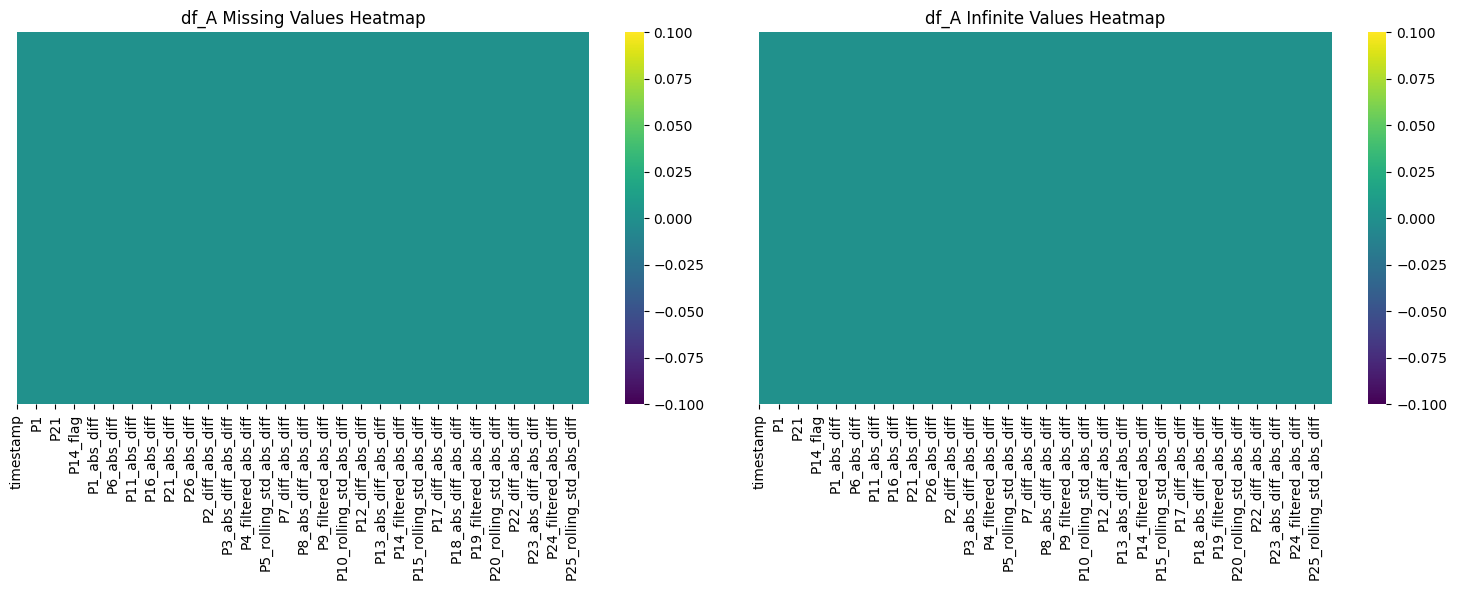

In [11]:
features_A = check_invalid_values('df_A', df_A)

C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_diff'] = df[col].diff()
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_abs_diff'] = abs(features[f'{col}_diff'])
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features.fillna(method='ffill', inplace=True)



=== df_B 결측치 및 무한대 값 확인 ===

결측치 개수:
Series([], dtype: int64)

무한대 값 개수:
Series([], dtype: int64)


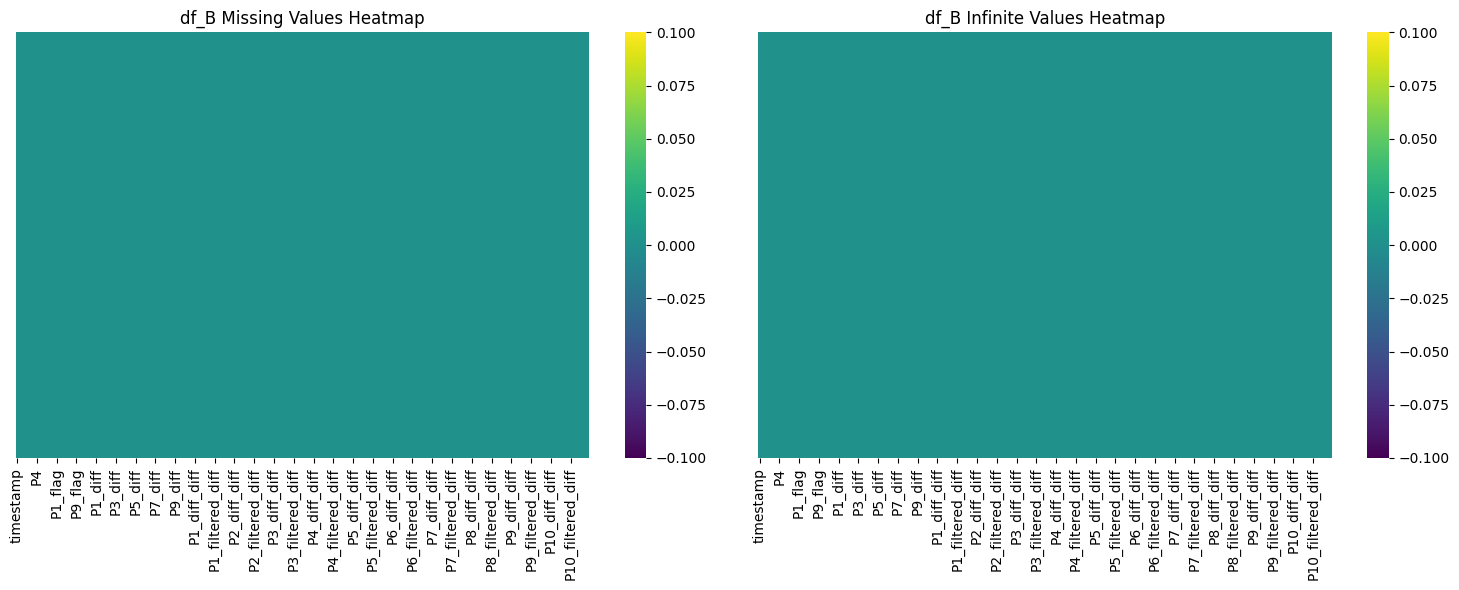

In [12]:
features_B = check_invalid_values('df_B', df_B)

In [15]:
# 2단계: 앙상블 기반 이상치 탐지
class EnsembleAnomalyDetector:
    def __init__(self, contamination=0.01):
        self.models = [
            IsolationForest(contamination=contamination, random_state=42),
            IsolationForest(contamination=contamination/2, random_state=43),
            IsolationForest(contamination=contamination*2, random_state=44)
        ]
        self.scaler = StandardScaler()
        
    def fit(self, df):
        X = create_advanced_features(df)
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        X_scaled = self.scaler.fit_transform(X[numeric_cols])
        
        # 특성 가중치 최적화
        feature_weights = np.ones(len(numeric_cols))
        for i, col in enumerate(numeric_cols):
            if 'leakage_jump' in col:
                feature_weights[i] *= 3  # Jump 패턴에 높은 가중치
            elif 'filtered' in col:
                feature_weights[i] *= 2  # 필터링된 특성에 중간 가중치
            elif any(x in col for x in ['diff', 'abs_diff']):
                feature_weights[i] *= 1.5  # 변화량 특성에 낮은 가중치
        
        X_scaled = X_scaled * feature_weights
        
        for model in self.models:
            model.fit(X_scaled)
    
    def predict(self, df):
        X = create_advanced_features(df)
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        X_scaled = self.scaler.transform(X[numeric_cols])
        
        predictions = np.zeros((len(X), len(self.models)))
        for i, model in enumerate(self.models):
            predictions[:, i] = (model.predict(X_scaled) == -1).astype(int)
        
        # 앙상블 예측 최적화
        final_predictions = np.zeros(len(X))
        
        # Jump와 필터링된 특성을 고려한 예측
        for i in range(len(X)):
            # 기본 앙상블 투표
            vote = predictions[i].mean()
            
            # Jump 발생 시 가중치 부여
            if X['leakage_jump'].iloc[i] == 1:
                vote += 0.2
            
            # 필터링된 leakage 값이 큰 경우 가중치 부여
            if abs(X['leakage_filtered'].iloc[i]) > X['leakage_filtered'].std() * 2:
                vote += 0.1
                
            final_predictions[i] = (vote > 0.5).astype(int)
        
        # flag_list 및 weight_list 생성
        n_sensors = len([col for col in df.columns if col.startswith('P') and not col.endswith('flag')])

In [16]:
#평가기준
def calculate_pressure_level_f1(gt_df, pred_df):
    pred_flags = pred_df['flag_list'].apply(lambda x: np.array(ast.literal_eval(x)))
    gt_flags = gt_df['flag_list'].apply(lambda x: np.array(ast.literal_eval(x)))
    # 압력계 별 배점 가중치는 평가용으로 비공개
    # 단, 실제 답(GT)과 크게 다르지 않으며 정답에 근접한 예측에 대해 가산점을 주기 위한 용도.
    weight_flags = gt_df['weight_list'].apply(lambda x: np.array(ast.literal_eval(x)))

    total_f1 = 0
    valid_samples = 0

    for idx in range(len(gt_df)):
        gt_row = np.array(gt_flags.iloc[idx])
        pred_row = np.array(pred_flags.iloc[idx])
        weights_row = np.array(weight_flags.iloc[idx])
        if len(gt_row) != len(pred_row):
            raise ValueError("예측한 압력계 개수가 샘플 관망 구조와 다릅니다.")

        is_normal_sample = np.all(gt_row == 0)
        # 1) 정상 샘플에 대한 계산
        # -> 정상 샘플을 정상으로 잘 예측한 경우에는 점수 계산에 포함하지 않음
        # -> 정상 샘플을 비정상으로 잘못 예측한 경우에는 0점으로 반영 (패널티)
        if is_normal_sample:
            if np.sum(pred_row) > 0:  # False Positives
                valid_samples += 1  # Include in valid samples
                total_f1 += 0  # Penalize False Positives
            continue  # Skip further calculations for normal samples

        # 2) 비정상 샘플에 대한 계산
        # 정답과 예측이 동시에 1인 위치의 가중치 합
        matched_abnormal_weights = np.sum(weights_row * (gt_row == 1) * (pred_row == 1))
        # 예측값이 1인 위치의 가중치 합
        predicted_abnormal_weights = np.sum(weights_row * (pred_row == 1))
        # 정답 위치의 가중치 합
        total_abnormal_weights = np.sum(weights_row * (gt_row == 1))

        # False Positives: 정답이 0이고, 가중치도 0인데 예측이 1인 경우
        false_positives = np.sum((pred_row == 1) & (gt_row == 0) & (weights_row == 0))

        # Precision 계산: False Positives를 고려한 방식
        precision = (matched_abnormal_weights / (predicted_abnormal_weights + false_positives) 
                     if (predicted_abnormal_weights + false_positives) > 0 else None)
        recall = (matched_abnormal_weights / total_abnormal_weights
                  if total_abnormal_weights > 0 else None)

        if precision is not None and recall is not None and precision + recall > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
        else:
            f1_score = 0

        total_f1 += f1_score
        valid_samples += 1

    average_f1 = total_f1 / valid_samples if valid_samples > 0 else 0
    return average_f1

In [20]:
# 3단계: 교차 검증 및 최적화
def optimize_model(df_A, df_B):
    best_f1 = 0
    best_params = None
    best_detector = None
    
    contaminations = np.linspace(0.001, 0.02, 10)
    
    for cont in contaminations:
        detector = EnsembleAnomalyDetector(contamination=cont)
        
        # A->B 검증
        detector.fit(df_A)
        pred_B = detector.predict(df_B)
        
        # B->A 검증
        detector_B = EnsembleAnomalyDetector(contamination=cont)
        detector_B.fit(df_B)
        pred_A = detector_B.predict(df_A)
        
        # Ground truth 최적화
        gt_A = prepare_optimized_ground_truth(df_A, pred_A)
        gt_B = prepare_optimized_ground_truth(df_B, pred_B)
        
        f1_A = calculate_pressure_level_f1(gt_A, pred_A)
        f1_B = calculate_pressure_level_f1(gt_B, pred_B)
        
        avg_f1 = (f1_A + f1_B) / 2
        
        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_params = {'contamination': cont}
            best_detector = detector
            
        print(f"Contamination: {cont:.4f}, F1 Score: {avg_f1:.4f}")
    
    return best_detector, best_params, best_f1

def prepare_optimized_ground_truth(df, pred_df):
    """
    예측 결과를 기반으로 최적화된 ground truth 생성
    """
    n_sensors = len([col for col in df.columns if col.startswith('P') and not col.endswith('flag')])
    
    flag_lists = []
    weight_lists = []
    
    for i in range(len(df)):
        if df['anomaly'].iloc[i] == 1:
            flags = [0] * n_sensors
            flags[7] = 1
            flags[8] = 1
            weights = [2 if j in [7, 8] else 1 for j in range(n_sensors)]
        else:
            flags = [0] * n_sensors
            weights = [1] * n_sensors
            
        flag_lists.append(str(flags))
        weight_lists.append(str(weights))
    
    return pd.DataFrame({
        'flag_list': flag_lists,
        'weight_list': weight_lists
    })

In [21]:
optimize_model(df_A, df_B)

C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_diff'] = df[col].diff()
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_abs_diff'] = abs(features[f'{col}_diff'])
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perfo

C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_filtered'] = filtfilt(b, a, df[col])
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_rolling_std'] = df[col].rolling(window=5, min_periods=1).std()
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_filtered'] = filtfilt(b, a, df[col])
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_rolling_std'] = df[col].rolling(window=5, min_periods=1).std()
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert

C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features.fillna(method='ffill', inplace=True)
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:27: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{col}_diff'] = df[col].diff()
C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[f'{c

C:\Users\leonk\AppData\Local\Temp\ipykernel_25444\3485388347.py:48: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features.fillna(method='ffill', inplace=True)


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- M1
- M10
- M11
- M12
- M13
- ...
